### Describe and Format Data for Modeling

- Joel Stremmel
- 01-08-24

##### About

Format the transcript data and survery responses to train binary classifiers with K-Fold cross-validation.

##### Imports

In [1]:
import os
import re
import glob
import torch
import pickle
import statistics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from pdfminer.high_level import extract_text
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
# from transformers import T5ForConditionalGeneration, T5Tokenizer, LlamaTokenizer, LlamaForCausalLM

##### Set Parameters

In [2]:
# Set sequence lengths for distribution plot and sentiment model
dist_max_seq_len = 32768

# Set model/tokenizer paths
dist_tokenizer_path = "roberta-base"

# Define data directory
pdf_dir = "./data/fall_2023/session_transcripts/"

# Define survey data path
survey_path = "./data/fall_2023/WDS_Session_Survey.xlsx"

# Group leaders
leaders_iter2 = [
    "Leader 1 (she/her)",
    "Leader 2 (she/her/hers)",
]

leaders_iter3 = [
    "Leader 1",
    "Leader 3"
]

# Define total number of sessions
num_sessions_iter2 = 10
num_sessions_iter3 = 12
total_num_sessions = num_sessions_iter2 + num_sessions_iter3

# Define the number of folds for K-Fold CV as a fraction  of the number of sessions
# Set to -1 for the number of folds to be equal to the number of sessions
# Otherwise, the number of folds is equal to the total number of sessions divided by this value
div_num_folds = 2 #-1

# Plot size
matplotlib.rcParams["figure.figsize"] = (9, 7)

# Set the default color cycle
CB_color_cycle = [
    "#377eb8",
    "#ff7f00",
    "#4daf4a",
    "#f781bf",
    "#a65628",
    "#984ea3",
    "#999999",
    "#e41a1c",
    "#dede00",
    "#000000",
    "#8DA0CB",
    "#A6D854",
    "#E5C494",
]
matplotlib.rcParams["axes.prop_cycle"] = matplotlib.cycler(color=CB_color_cycle)

# Define separator token for utterances
sep_token = "</s>"

# Outcome variable
outcome = 'Alliance' #'cohesion' # "Alliance"

# Define outcome cutoff
outcome_cutoff = 36 # 36  # 4

# Optionally add a summary of each transcript to the text data
add_summaries = False

# ADD THE ABILITY TO SUMMARIZE INDIVIDUAL PARTICIPANT UTTERANCES!!!
# COMBINE WITH SESSION TRANSCRIPT SUMMARIES

# Define a seperator other than the sep token if adding summary
# Instead of seperating utterances with the sep token, this approach
# Uses the sep token to seperate the summary from the utterances and another
# Token to seperate utterances
utterance_seperator = "\n\n"

# Define model to use for summarization and number of beams for text generation
# summarizer_path = "togethercomputer/Llama-2-7B-32K-Instruct"
summarizer_path = "Salesforce/xgen-7b-8k-inst"
max_transcript_seq_len = 8096
max_summary_seq_len = 128
temperature = 0.2
repetition_penalty = 1.1
top_p = 0.7
top_k = 50

# [INST] not required for mpt LLM - this was for llama2 32k instruct
prompt_prefix = f"Summarize the following group therapy session transcript with respect to overall group {outcome.lower()}:\n\n"
prompt_suffix = "\n"

# Define a place to save the summaries for reference
summaries_output_file_iter2 = "results/summaries_iter2.txt"
summaries_output_file_iter3 = "results/summaries_iter3.txt"

##### Load Tokenizer

In [3]:
dist_tokenizer = AutoTokenizer.from_pretrained(dist_tokenizer_path)

##### Load Survey Data

In [4]:
df = pd.read_excel(survey_path)
df.shape

(141, 18)

##### Define Score and Text Dataframes from Surveys

In [5]:
score_df = df[
    ["wdscode",
     "pseudonym",
     "id",
     "iteration",
     "session",
     outcome
    ]
]

##### Handle Nulls
For now, drop rows where the outcome rating is missing.

In [6]:
score_df = score_df[~df[[outcome]].isnull().any(axis=1)]

##### Fix Casing
There were some other typos of participants names in the Excel file that I manually fixed.

In [7]:
score_df['wdscode'] = score_df['wdscode'].apply(lambda x: x.capitalize())

##### Identify Participants

In [8]:
participant_text_names_iter2 = [x + '_2' for x in score_df[score_df['iteration'] == 2]['pseudonym'].unique()]

In [9]:
participant_text_names_iter2

['Betty_2',
 'Martha_2',
 'Sharon_2',
 'Cecilia_2',
 'Addison_2',
 'Gemma_2',
 'Bonnie_2',
 'Penny_2',
 'Tanya_2',
 'Maya_2']

In [10]:
participants_iter2 = score_df[score_df['iteration'] == 2]['wdscode'].unique().tolist()

In [11]:
participants_iter2

['Greendog6',
 'Bluecat11',
 'Purplepanda5',
 'Greenbird10',
 'Pinkrat9',
 'Greenpanda4',
 'Tealpika8',
 'Pinkelephant7',
 'Purplepangolin2',
 'Purpledolphin6']

In [12]:
participants_iter3 = score_df[score_df['iteration'] == 3]['wdscode'].unique().tolist()

In [13]:
participants_iter3

['Silverdog7',
 'Purplelion6',
 'Bluephoenix08',
 'Purpledog8',
 'Redmonkey7',
 'Greendino4',
 'Purpledragonfly9',
 'Dustyrosechihuahua5',
 'Rainbowwhale7']

##### View Outcome Distribution for Participants

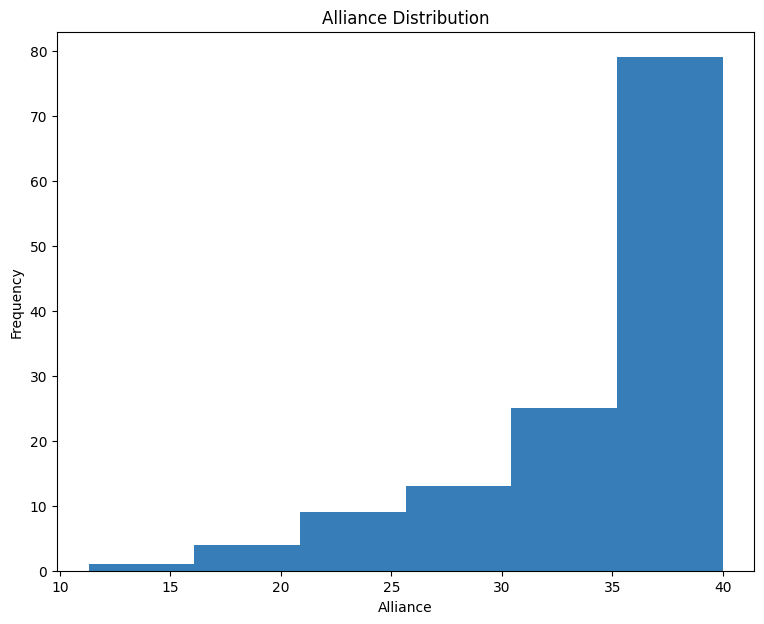

In [14]:
plt.hist(score_df[outcome], bins=6)
plt.xlabel(outcome)
plt.ylabel("Frequency")
plt.title(f"{outcome} Distribution")
plt.show()

##### View Binarized Outcome Distribution for Participants

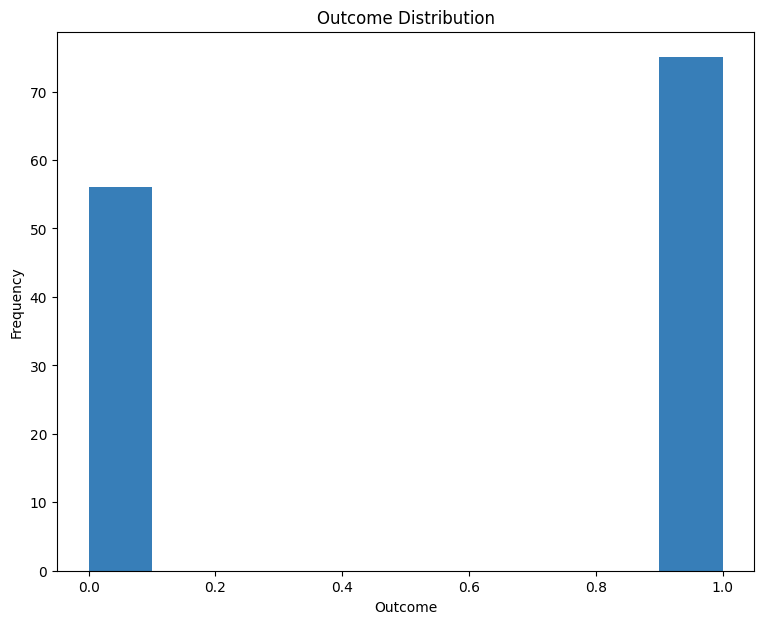

Below cutoff: 56.
Above cutoff: 75.


In [15]:
plt.hist([1 if x >= outcome_cutoff else 0 for x in score_df[outcome].tolist()])
plt.xlabel("Outcome")
plt.ylabel("Frequency")
plt.title("Outcome Distribution")
plt.show()

print(f"Below cutoff: {score_df[score_df[outcome] < outcome_cutoff].shape[0]}.")
print(f"Above cutoff: {score_df[score_df[outcome] >= outcome_cutoff].shape[0]}.")

##### Plot Scores per Participant per Session

In [16]:
def plot_scores_per_participant_per_session(participants, outcome):
    
    fig, ax = plt.subplots()
    for participant in participants:
        x = score_df[score_df["wdscode"] == participant]["session"].tolist()
        y = score_df[score_df["wdscode"] == participant][outcome].tolist()
        ax.plot(x, y, label=participant)

        # Set plot title and axis labels
        ax.set_title(f"{outcome} per Session per Participant")
        ax.set_xlabel("Session Number")
        ax.set_ylabel(f"{outcome}")

        # Set legend
        ax.legend(fontsize=6, loc="best")

    # Show plot
    plt.show()

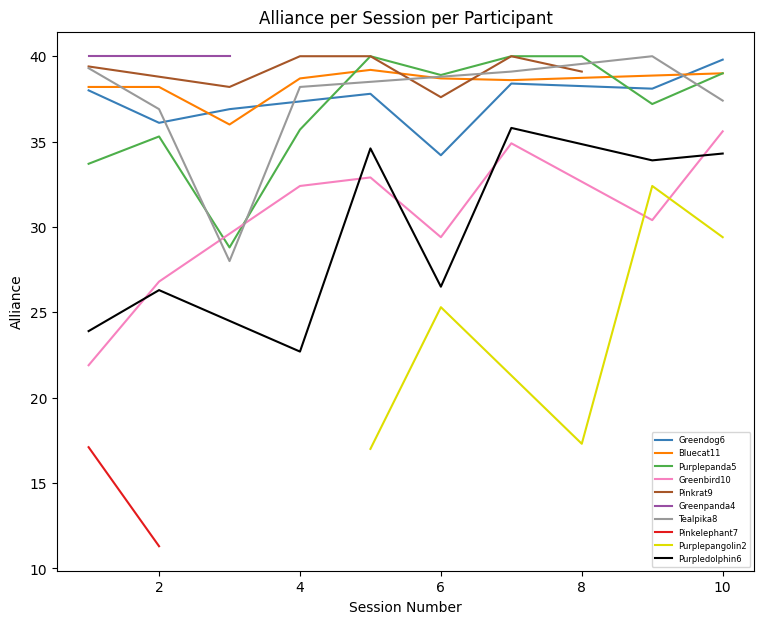

In [17]:
plot_scores_per_participant_per_session(participants_iter2, outcome)

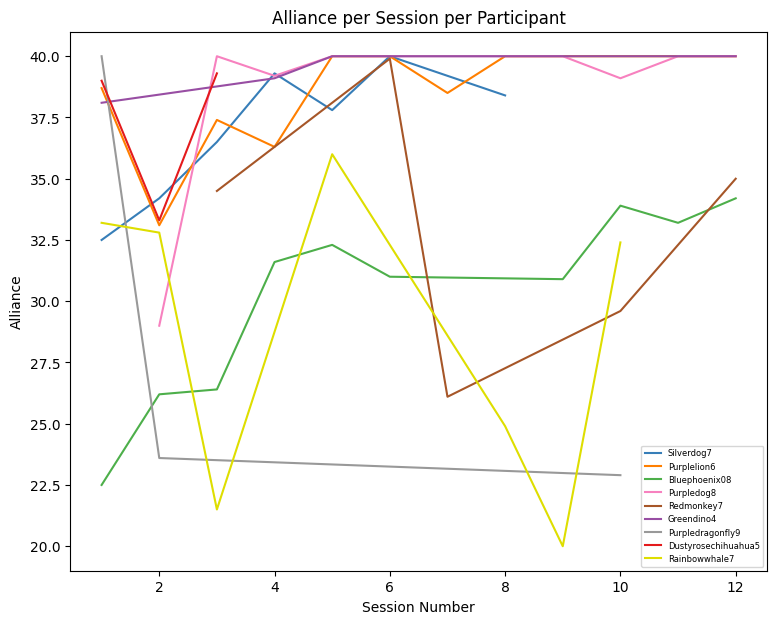

In [18]:
plot_scores_per_participant_per_session(participants_iter3, outcome)

##### Collect PDFs of Transcripts

In [19]:
iter2_pdf_files = glob.glob(os.path.join(os.path.join(pdf_dir, 'WDS2'), "*.pdf"))
iter3_pdf_files = glob.glob(os.path.join(os.path.join(pdf_dir, 'WDS3'), "*.pdf"))

##### Define Function to Remove Lines

In [20]:
def should_remove(line):
    line = line.strip()
    if line.isdigit() or not line or (line.startswith("{") and line.endswith("}")) or 'WDS Iteration' in line:
        return True

##### Extract Text and Collect Utterances

In [21]:
def collect_utterances(pdf_files, speakers):

    # Save complete utterances
    speaker_utterances = {
        speaker: {num: [] for num in range(len(pdf_files))} for speaker in speakers
    }

    # Save session text
    session_texts = []

    # Iterate through files to extract words
    for i, file in enumerate(pdf_files):
        # Reset current speaker
        current_speaker = None

        # Reset utterance
        utterance = ""

        # Extract text
        text = extract_text(file)

        # Replace \x0c chars with empty strings
        pattern = r"\x0c\d+"
        text = re.sub(pattern, "", text)

        # Replace tabs with spaces
        text = text.replace("\t", " ")

        # Save texts with single newlines removed but not double newlines
        pattern = r"(?<!\n)\n(?!\n)"
        session_texts.append(re.sub(pattern, "", text))

        # Iterate through text split on newlines
        for line in text.split("\n"):
            # If the line is blank, keep going
            if not line or line.strip() == "" or line == "\n":
                continue

            # Check if one of the speakers is speaking
            for speaker in speakers:
                if line.startswith(speaker + ":"):
                    # If the current speaker is the same as this speaker, keep going
                    if current_speaker == speaker:
                        break

                    # Otherwise, we have a new speaker and we want to save the full utterance
                    # from the previous speaker, set the new speaker, and reset the utterance
                    # If the current speaker is None, it's our first iteration and there's
                    # Nothing to save
                    else:
                        if current_speaker is None:
                            assert utterance == "", "Expected utterance to be empty."
                        else:
                            speaker_utterances[current_speaker][i].append(utterance)
                        current_speaker = speaker
                        utterance = ""

            # If we have a current speaker, add the utterance
            if current_speaker:
                # Handle empty lines, bracketted info, and page numbers
                if should_remove(line):
                    continue

                # Remove the speaker name from the line
                # Split on any number of whitespaces to define the words in the line
                clean_line = line.replace(current_speaker + ":", "")

                # Add to the utterance which will contain words seperated only by single spaces
                utterance += " ".join(clean_line.split())
                
    return speaker_utterances, session_texts

In [22]:
speaker_utterances_iter2, session_texts_iter2 = collect_utterances(
    pdf_files=iter2_pdf_files, 
    speakers=participant_text_names_iter2 + leaders_iter2
)

In [23]:
speaker_utterances_iter3, session_texts_iter3 = collect_utterances(
    pdf_files=iter3_pdf_files,
    speakers=participants_iter3 + leaders_iter3
)

##### Define Function to Differentiate between Participants and Leaders

In [24]:
def add_leader_tag(d, leaders):
    d_plot = {}
    for k, v in d.items():
        if k in leaders:
            d_plot[k + " - Leader"] = v
        else:
            d_plot[k] = v

    return d_plot

##### Plot the Number of Utterances from Each Speaker for Each Session

In [25]:
def plot_num_utterances_per_speaker_per_session(speaker_utterances, leaders):
    
    # Create plot
    fig, ax = plt.subplots()
    for key in speaker_utterances:
        x = list(speaker_utterances[key].keys())
        y = [len(speaker_utterances[key][i]) for i in x]

        if key in leaders:
            label = key + " - Leader"
        else:
            label = key

        ax.plot(x, y, label=label)

    # Set plot title and axis labels
    ax.set_title("Number of Utterances per Session per Speaker")
    ax.set_xlabel("Session Number")
    ax.set_ylabel("Number of Utterances")

    # Set legend
    ax.legend(fontsize=6, loc="best")

    # Show plot
    plt.show()

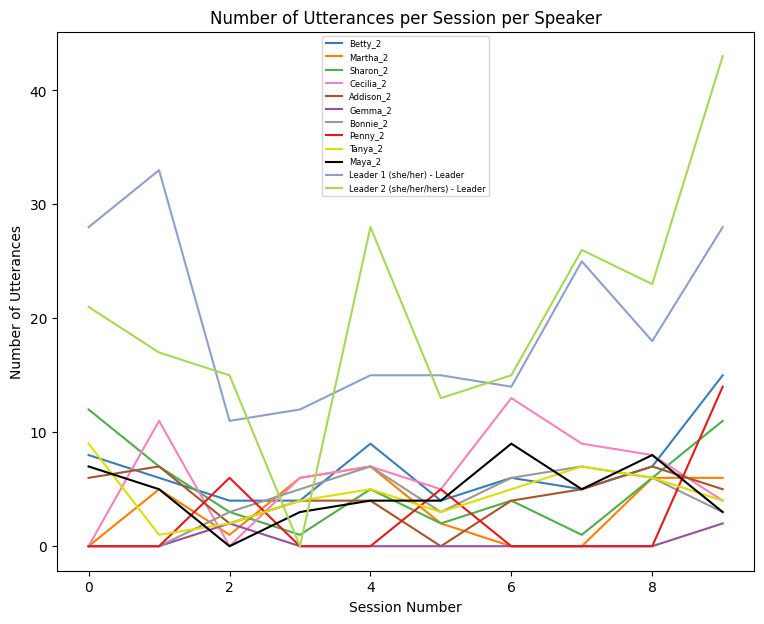

In [26]:
plot_num_utterances_per_speaker_per_session(speaker_utterances_iter2, leaders_iter2)

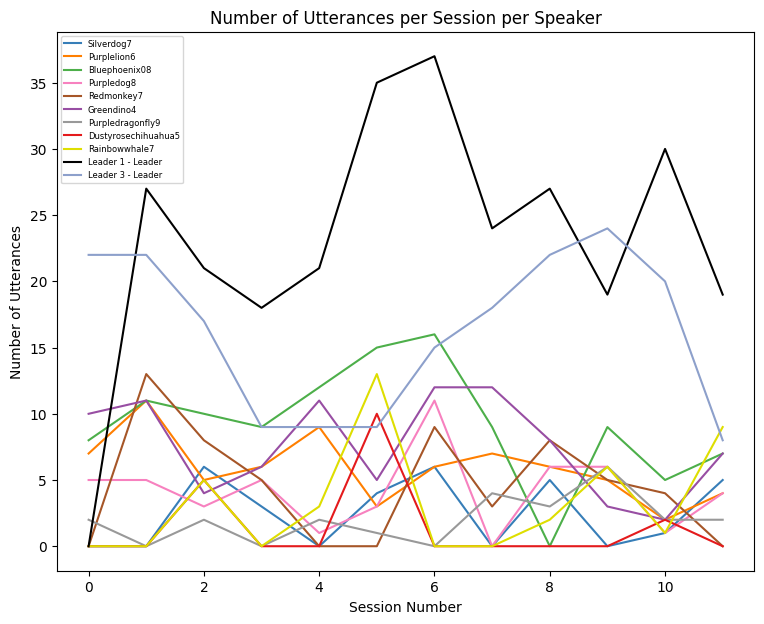

In [27]:
plot_num_utterances_per_speaker_per_session(speaker_utterances_iter3, leaders_iter3)

##### Filter to Participants

In [28]:
participant_utterances_iter2 = {
    k: v for k, v in speaker_utterances_iter2.items() if k not in leaders_iter2
}

participant_utterances_iter3 = {
    k: v for k, v in speaker_utterances_iter3.items() if k not in leaders_iter3
}

##### Plot the Number of Tokens for all Utterances from Each Participant for Each Session and Save Utterance Text and Scores

In [29]:
def save_utterance_text_and_scores(participant_utterances, leaders, participant_id):

    # Create lists to save utterance text, participant scores, and participant names
    X_fold_text = []
    y_fold_score = []
    participant_fold_names = []

    # Generate plots and the data to fill the lists above by iterating through all participant utterances
    fig, ax = plt.subplots()
    for participant, session2utterances in participant_utterances.items():
        
        # We'll use these for the plot
        x = list(session2utterances.keys())
        y = []

        # Fill the empty lists above with info for this participant from each session
        for i in x:
            
            # Build list of all utterances for this participant
            all_utterances = session2utterances[i]

            # Add the sep token to the utterance text to separate utterances and combine them into one string
            all_utterance_text = sep_token.join(all_utterances)

            # Get the outcome score for the given session and participant
            # Note that the session numbers start at 1 in score_df
            s_num = i + 1
            
            if participant_id == "pseudonym":
                
                score_row = score_df[
                    (score_df["session"] == s_num) & (score_df["pseudonym"] == participant.replace('_2', ''))
                ][outcome]
                
            elif participant_id == "wdscode":
                
                score_row = score_df[
                    (score_df["session"] == s_num) & (score_df["wdscode"] == participant)
                ][outcome]

            # Check that either the score is missing and the row is empty or there is one value for the score
            assert score_row.shape[0] in [
                0,
                1,
            ], f"{score_row.shape[0]} rows with values {score_row} for participant {participant} at session {s_num}."

            # If a non-missing score is recorded, save it along with the utterance text and participant name and ID
            if score_row.shape[0] == 1 and not score_row.isnull().values.any():
                X_fold_text.append(all_utterance_text)
                y_fold_score.append(score_row.item())
                participant_fold_names.append((i, participant))

            # Compute the number of subwords in the utterance text
            tokenized_text = dist_tokenizer(
                all_utterance_text,
                padding=False,
                truncation=True,
                max_length=dist_max_seq_len,
            )
            num_subwords = len(tokenized_text["input_ids"])
            y.append(num_subwords)

        ax.plot(x, y, label=participant)

    # Set plot title and axis labels
    ax.set_title("All Utterances Length in Tokens per Session per Speaker")
    ax.set_xlabel("Session Number")
    ax.set_ylabel("All Utterances Length in Tokens")

    # Set legend
    ax.legend(fontsize=6, loc="best")

    # Show plot
    plt.show()
    
    return X_fold_text, y_fold_score, participant_fold_names

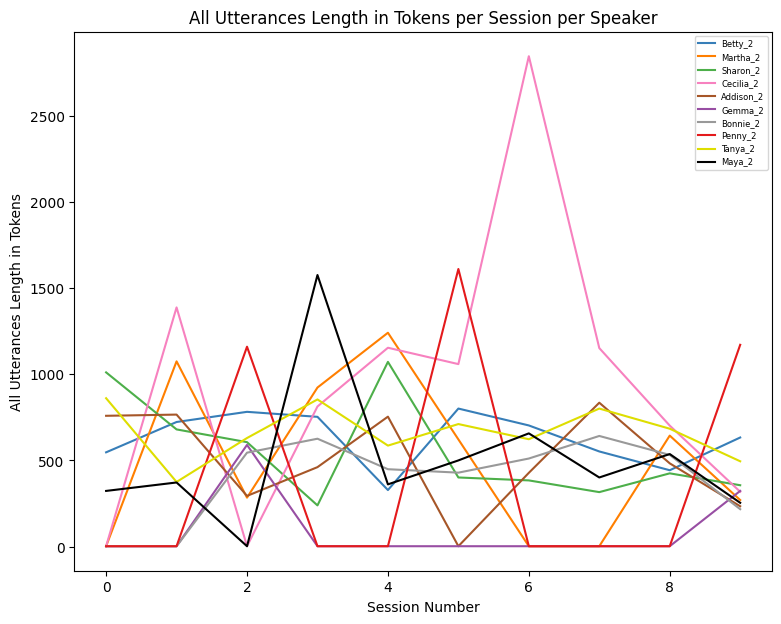

In [30]:
X_fold_text_iter2, y_fold_score_iter2, participant_fold_names_iter2 = save_utterance_text_and_scores(
    participant_utterances=participant_utterances_iter2, 
    leaders=leaders_iter2,
    participant_id="pseudonym"
)

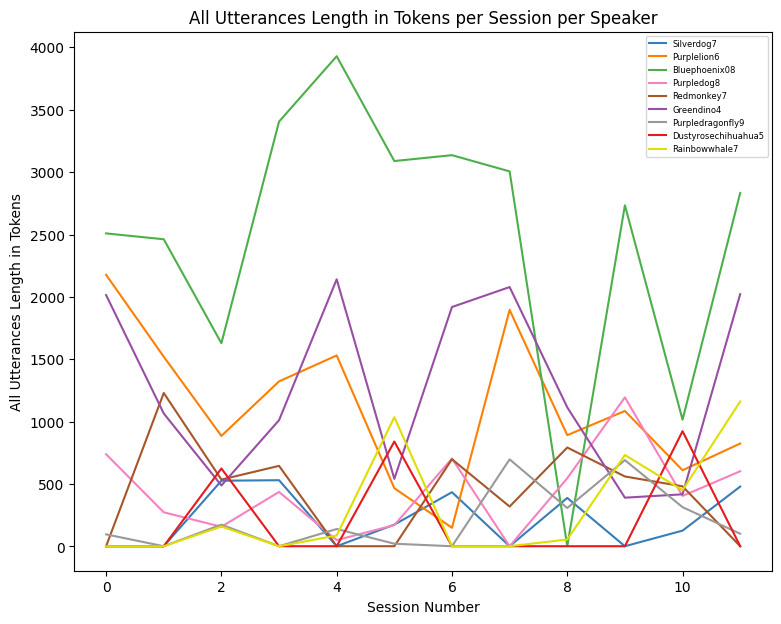

In [31]:
X_fold_text_iter3, y_fold_score_iter3, participant_fold_names_iter3 = save_utterance_text_and_scores(
    participant_utterances=participant_utterances_iter3, 
    leaders=leaders_iter3,
    participant_id="wdscode"
)

##### Summarize Transcripts
A prompt focused on the goal of providing the overall sentiment of the session might performance better than simply asking for a summary.

In [32]:
def summarize_session_texts(session_texts, summaries_output_file):
    
    # Load summarizer    
    summarizer_tokenizer = AutoTokenizer.from_pretrained(summarizer_path, trust_remote_code=True)
    summarizer = AutoModelForCausalLM.from_pretrained(summarizer_path, device_map='cpu')

    # Iterate over documents and summarize them
    summaries = []
    for sequence in session_texts:
        # Tokenize input sequence with prefix
        input_ids = summarizer_tokenizer.encode(
            prompt_prefix + sequence + prompt_suffix,
            return_tensors="pt",
            max_length=max_transcript_seq_len,
            truncation=True,
        )

        # Generate summary
        summary_ids = summarizer.generate(
            input_ids,
            do_sample=True,
            max_new_tokens=max_summary_len,
            top_k=top_k,
            eos_token_id=50256
        )
    

        # Decode summary
        summary = summarizer_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)

    with open(summaries_output_file, "w") as f:
        for line in summaries:
            f.write(f"{line}\n")
            
    return summaries

In [33]:
if add_summaries:
    
    summaries_iter2 = summarize_session_texts(
        session_texts=session_texts_iter2,
        summaries_output_file=summaries_output_file_iter2
    )
    
    summaries_iter3 = summarize_session_texts(
        session_texts=session_texts_iter3,
        summaries_output_file=summaries_output_file_iter3
    )

##### Turn Saved Utterance Text and Scores into Data Folds and Threshold Scores
- This assumes the data will be used to train binary classifiers with K-Fold cross-validation where K is equal to the number of sessions and the the binary outcome variable is defined according to `outcome_cutoff`.
- If desired, the code block combines a summary of the entire transcript with all utterances for a given participant using the sep token to separate the summary for the utterances and a special utterance seperator to seperate utterances.

In [34]:
def create_folds(
    num_sessions,
    participant_fold_names,
    X_fold_text,
    y_fold_score,
    add_summaries,
    summaries,
    sep_token, 
    utterance_seperator
):

    X_folds = {i: [] for i in range(num_sessions)}
    y_folds = {i: [] for i in range(num_sessions)}
    names = {i: [] for i in range(num_sessions)}

    for record, text, score in zip(participant_fold_names, X_fold_text, y_fold_score):
        if not text or text.strip() == "" or text == "\n":
            continue

        session_number = record[0]
        name = record[1]

        binary_score = 1 if score >= outcome_cutoff else 0

        if add_summaries:
            summary = summaries[session_number]
            sample_text = summary + sep_token + text.replace(sep_token, utterance_seperator)
        else:
            sample_text = text

        X_folds[session_number].append(sample_text)
        y_folds[session_number].append(binary_score)
        names[session_number].append(name)
        
    return X_folds, y_folds, names

In [35]:
X_folds_iter2, y_folds_iter2, names_iter2 = create_folds(
    num_sessions=num_sessions_iter2,
    participant_fold_names=participant_fold_names_iter2,
    X_fold_text=X_fold_text_iter2,
    y_fold_score=y_fold_score_iter2,
    add_summaries=add_summaries,
    summaries=summaries_iter2 if add_summaries else None,
    sep_token=sep_token, 
    utterance_seperator=utterance_seperator
)

In [36]:
X_folds_iter3, y_folds_iter3, names_iter3 = create_folds(
    num_sessions=num_sessions_iter3,
    participant_fold_names=participant_fold_names_iter3,
    X_fold_text=X_fold_text_iter3,
    y_fold_score=y_fold_score_iter3,
    add_summaries=add_summaries,
    summaries=summaries_iter3 if add_summaries else None,
    sep_token=sep_token, 
    utterance_seperator=utterance_seperator
)

##### Merge Folds from all Iterations

In [37]:
def merge_folds(all_X_folds, all_y_folds, all_names):

    merged_X_folds = {}
    merged_y_folds = {}
    merged_names = {}
    
    fold_idx = 0
    for i in range(len(all_names)):
        for xs, ys, names in zip(all_X_folds[i].values(), all_y_folds[i].values(), all_names[i].values()):
            merged_X_folds[fold_idx] = xs
            merged_y_folds[fold_idx] = ys
            merged_names[fold_idx] = names
            fold_idx += 1
            
    return merged_X_folds, merged_y_folds, merged_names

X_folds, y_folds, names = merge_folds(
    all_X_folds=[X_folds_iter2, X_folds_iter3],
    all_y_folds=[y_folds_iter2, y_folds_iter3],
    all_names=[names_iter2, names_iter3]
)

##### Optionally Combine Folds 
If desired, K can be less than the number of sessions. Use `div_num_folds` to reduce the number of folds to `num_sessions` / `div_num_folds`.

In [38]:
if div_num_folds > 0:
    X_folds = {
        fold: X_folds[i] + X_folds[i + 1]
        for fold, i in enumerate(range(0, total_num_sessions, div_num_folds))
    }
    y_folds = {
        fold: y_folds[i] + y_folds[i + 1]
        for fold, i in enumerate(range(0, total_num_sessions, div_num_folds))
    }
    names = {
        fold: names[i] + names[i + 1]
        for fold, i in enumerate(range(0, total_num_sessions, div_num_folds))
    }

##### Pickle the Data to Use for Modeling

In [39]:
if add_summaries:
    with open(f"data/{outcome}_Xwsum_folds.pkl", "wb") as f:
        pickle.dump(X_folds, f)
else:
    with open(f"data/{outcome}_X_folds.pkl", "wb") as f:
        pickle.dump(X_folds, f)

with open(f"data/{outcome}_y_folds.pkl", "wb") as f:
    pickle.dump(y_folds, f)

with open(f"data/{outcome}_names.pkl", "wb") as f:
    pickle.dump(names, f)